In [1]:
%pylab inline --no-import-all
from __future__ import division

import pandas as pd
import seaborn as sns
import numpy as np

import time
import datetime
from datetime import datetime

import pytz
utc=pytz.UTC

import pyfolio as pf

figsize(13, 9)

Populating the interactive namespace from numpy and matplotlib


In [2]:
SPY = pf.utils.get_symbol_rets('SPY')
GLD = pf.utils.get_symbol_rets('GLD')
TLT = pf.utils.get_symbol_rets('TLT')
EEM = pf.utils.get_symbol_rets('EEM')
FXE = pf.utils.get_symbol_rets('FXE')
SPY.name = 'SPY'
GLD.name = 'GLD'
TLT.name = 'TLT'
EEM.name = 'EEM'
FXE.name = 'FXE'
stocks_str = ['SPY', 'GLD', 'TLT', 'EEM' , 'FXE']
stocks = [SPY, GLD, TLT, EEM, FXE]
stocks_df_na = pd.DataFrame(stocks).T
stocks_df_na.columns = stocks_str
stocks_df = stocks_df_na.dropna()

# Equal-weight Portfolio

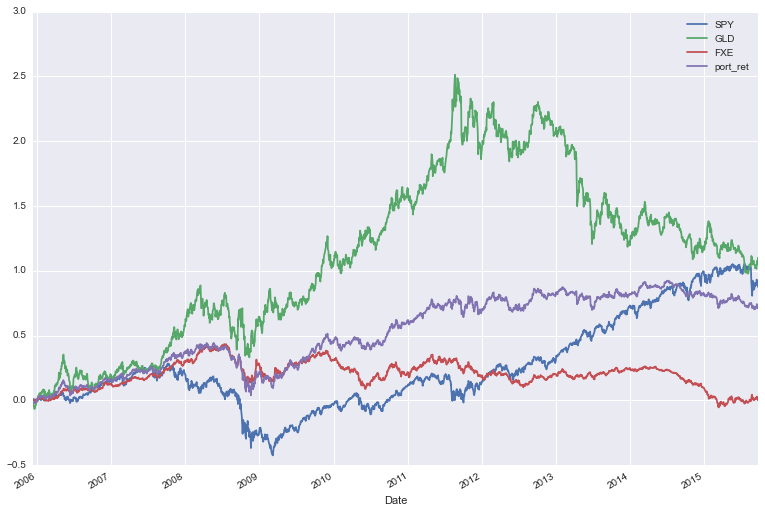

In [3]:
# USAGE: Equal-Weight Portfolio.
# 1) if 'exclude_non_overlapping=True' below, the portfolio will only contains 
#    days which are available across all of the algo return timeseries.
# 
#    if 'exclude_non_overlapping=False' then the portfolio returned will span from the
#    earliest startdate of any algo, thru the latest enddate of any algo.
#
# 2) Weight of each algo will always be 1/N where N is the total number of algos passed to the function

portfolio_rets_ts, data_df = pf.timeseries.portfolio_returns_metric_weighted([SPY, FXE, GLD],
                                                                             exclude_non_overlapping=True
                                                                            )
to_plot = ['SPY', 'GLD', 'FXE'] + ["port_ret"]
data_df[to_plot].apply(pf.timeseries.cum_returns).plot()

In [4]:
pf.timeseries.perf_stats(data_df['port_ret'])

,perf_stats
annual_return,0.064791
annual_volatility,0.120130
sharpe_ratio,0.539345
calmar_ratio,0.231585
stability,0.849609
max_drawdown,-0.279773
omega_ratio,1.098343
sortino_ratio,0.734911
skewness,-0.011279
kurtosis,5.771776


# Volatility-weighted Portfolio (using just np.std as weighting metric)

In [5]:
# USAGE: Portfolio based on volatility weighting.
# The higher the volatility the _less_ weight the algo gets in the portfolio
# The portfolio is rebalanced monthly. For quarterly reblancing, set portfolio_rebalance_rule='Q'


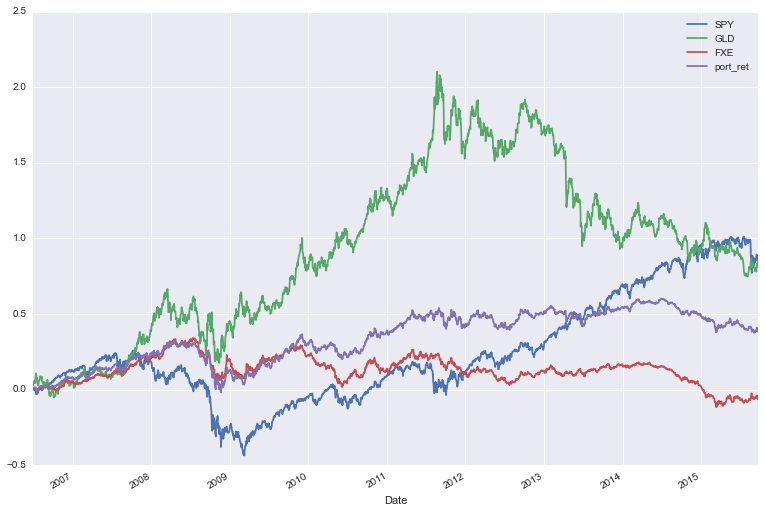

In [6]:
stocks_port, data_df = pf.timeseries.portfolio_returns_metric_weighted([SPY, FXE, GLD], 
                                                                       weight_function=np.std, 
                                                                       weight_function_window=126, 
                                                                       inverse_weight=True
                                                                      )
to_plot = ['SPY', 'GLD', 'FXE'] + ["port_ret"]
data_df[to_plot].apply(pf.timeseries.cum_returns).plot()

In [7]:
pf.timeseries.perf_stats(data_df['port_ret'])

,perf_stats
annual_return,0.042424
annual_volatility,0.108149
sharpe_ratio,0.392272
calmar_ratio,0.163445
stability,0.745001
max_drawdown,-0.259562
omega_ratio,1.071104
sortino_ratio,0.540178
skewness,0.051885
kurtosis,4.729615


# Volatility-weighted Portfolio (with constraint of no asset weight to be greater than 2x any other asset weight. Function def min_max_vol_bounds defines the the constraint)

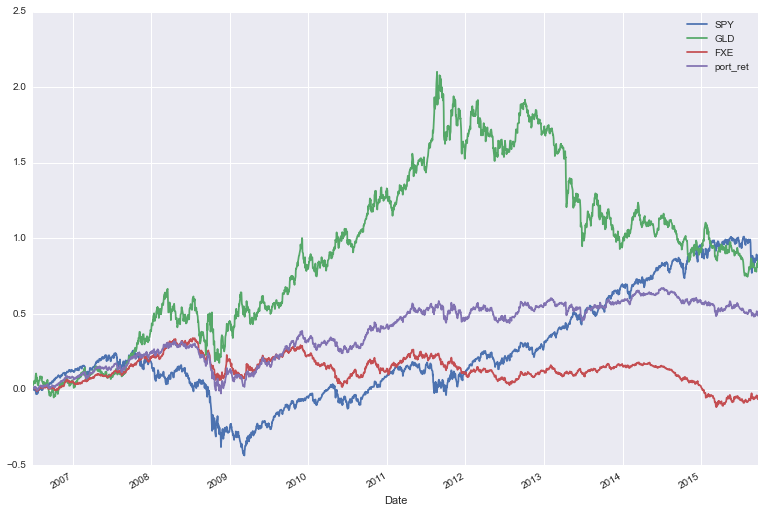

In [8]:
stocks_port, data_df = pf.timeseries.portfolio_returns_metric_weighted([SPY, FXE, GLD], 
                                                                       weight_function=np.std,
                                                                       weight_func_transform=pf.timeseries.min_max_vol_bounds,
                                                                       weight_function_window=126, 
                                                                       inverse_weight=True)
to_plot = ['SPY', 'GLD', 'FXE'] + ["port_ret"]
data_df[to_plot].apply(pf.timeseries.cum_returns).plot()

In [9]:
pf.timeseries.perf_stats(data_df['port_ret'])

,perf_stats
annual_return,0.051317
annual_volatility,0.112164
sharpe_ratio,0.457519
calmar_ratio,0.195224
stability,0.808207
max_drawdown,-0.262862
omega_ratio,1.082661
sortino_ratio,0.625652
skewness,-0.030271
kurtosis,4.551370


# Quantized bucket Volatility-weighted Portfolio (using custom function bucket_std() as weighting metric)

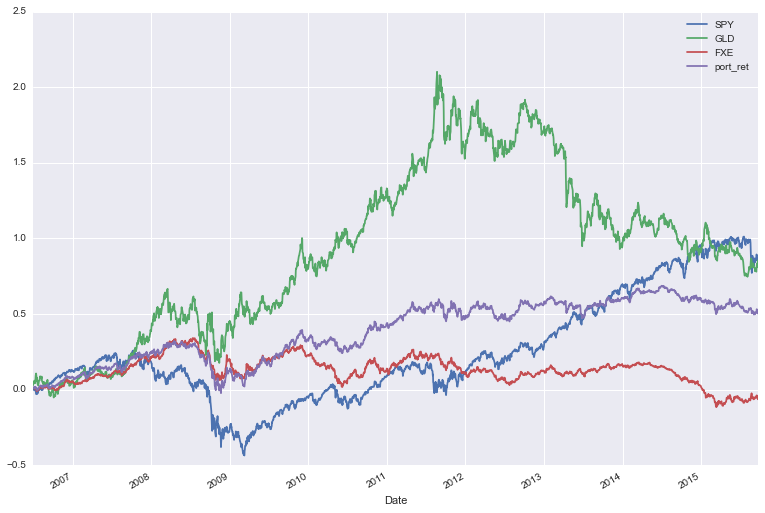

In [10]:
stocks_port, data_df = pf.timeseries.portfolio_returns_metric_weighted([SPY, FXE, GLD], 
                                                                       weight_function=np.std,
                                                                       weight_func_transform=pf.timeseries.bucket_std,
                                                                       weight_function_window=126, 
                                                                       inverse_weight=True)
to_plot = ['SPY', 'GLD', 'FXE'] + ["port_ret"]
data_df[to_plot].apply(pf.timeseries.cum_returns).plot()

In [11]:
pf.timeseries.perf_stats(data_df['port_ret'])

,perf_stats
annual_return,0.052412
annual_volatility,0.111722
sharpe_ratio,0.469126
calmar_ratio,0.200400
stability,0.815124
max_drawdown,-0.261535
omega_ratio,1.084771
sortino_ratio,0.643481
skewness,-0.009548
kurtosis,4.521020
